<a href="https://colab.research.google.com/github/eyaler/workshop/blob/master/output/nn_3_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. How to train and test your network (CIFAR)

In [1]:
%tensorflow_version 1.x
!pip install keras==2.2.5
!pip install livelossplot
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import Input, Model
from keras.layers import Dense, Dropout
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
from livelossplot import PlotLossesKeras
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
!nvidia-smi -L

TensorFlow 1.x selected.


Using TensorFlow backend.


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-4a7679a0-4485-0695-45ca-b628a41d4de8)


In [2]:
# set random seeds for more reproducible results
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(43)

In [3]:
# load dataset
#(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = mnist.load_data()
(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = cifar10.load_data()
print(raw_x_train.shape, raw_y_train.shape)
if len(raw_x_train.shape)==4:
    raw_x_train = np.mean(raw_x_train, axis=-1, keepdims=True)
    raw_x_test = np.mean(raw_x_test, axis=-1, keepdims=True)
if len(raw_x_train.shape)==3:
    raw_x_train = np.expand_dims(raw_x_train, axis=-1)
    raw_x_test = np.expand_dims(raw_x_test, axis=-1)
train_size = len(raw_y_train)
test_size = len(raw_y_test)
xdim = raw_x_train.shape[1]
ydim = raw_x_train.shape[2]
print(raw_x_train.dtype, raw_y_train.dtype)

(50000, 32, 32, 3) (50000, 1)
float64 uint8


[[[ 61.33333333]
  [ 44.66666667]
  [ 47.        ]
  ...
  [132.66666667]
  [126.33333333]
  [125.        ]]

 [[ 18.66666667]
  [  0.        ]
  [  8.66666667]
  ...
  [ 88.66666667]
  [ 84.        ]
  [ 88.66666667]]

 [[ 23.33333333]
  [  7.66666667]
  [ 28.        ]
  ...
  [ 84.        ]
  [ 84.66666667]
  [ 74.66666667]]

 ...

 [[158.        ]
  [129.33333333]
  [128.33333333]
  ...
  [121.        ]
  [ 31.33333333]
  [ 35.66666667]]

 [[138.33333333]
  [112.66666667]
  [120.        ]
  ...
  [142.        ]
  [ 64.33333333]
  [ 56.66666667]]

 [[145.66666667]
  [130.33333333]
  [136.        ]
  ...
  [180.        ]
  [117.66666667]
  [ 95.66666667]]]
[6]


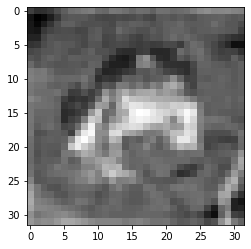

In [4]:
print(raw_x_train[0])
print(raw_y_train[0])
if raw_x_train.shape[-1]==1:
    plt.imshow(raw_x_train[0][..., 0], cmap='gray')
else:
    plt.imshow(raw_x_train[0])

In [5]:
print(np.min(raw_x_train), np.max(raw_x_train), np.median(raw_x_train))
print(np.unique(raw_y_train, return_counts=True))
print(np.unique(raw_y_test, return_counts=True))

0.0 255.0 116.33333333333333
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


In [6]:
n_classes = len(np.unique(raw_y_test))
x_train, y_train = shuffle(raw_x_train, raw_y_train, random_state=44)
x_train = x_train.reshape((train_size, -1))/255
x_test = raw_x_test.reshape((test_size, -1))/255
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(raw_y_test, n_classes)
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

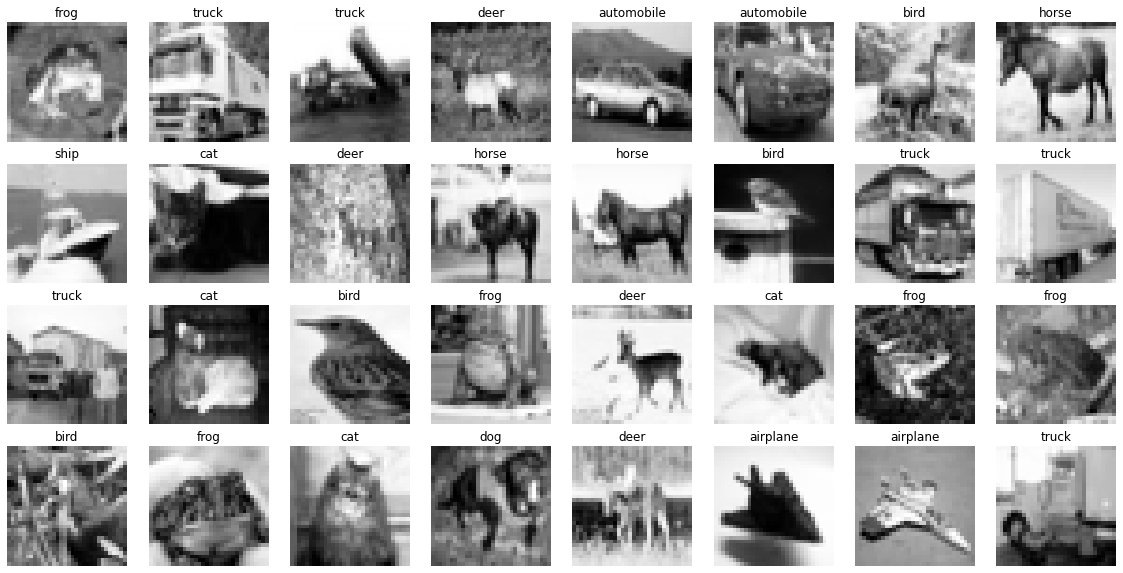

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid

#helper function to plot in grids
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(label_list[i])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

show_grid(raw_x_train[:32],4,8,label_list=[class_names[i] for i in np.squeeze(raw_y_train[:32])],show_labels=True,figsize=(20,10))

In [8]:
dropout_prob = 0.5

def get_model():
    inputs = Input(shape=(xdim*ydim,))
    f = Dense(1024, activation='relu')(inputs)
    f = Dropout(dropout_prob)(f)
    f = Dense(1024, activation='relu')(f)
    f = Dropout(dropout_prob)(f)
    f = Dense(256, activation='relu')(f)
    f = Dropout(dropout_prob)(f)
    outputs = Dense(n_classes, activation='softmax')(f)
    return Model(inputs=inputs, outputs=outputs)

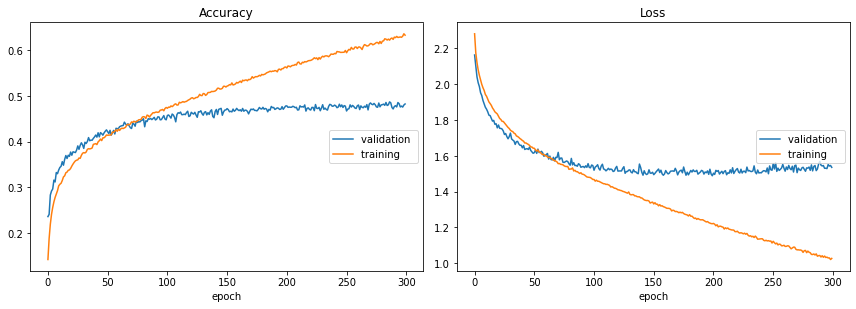

Accuracy
	validation       	 (min:    0.236, max:    0.487, cur:    0.483)
	training         	 (min:    0.142, max:    0.636, cur:    0.633)
Loss
	validation       	 (min:    1.489, max:    2.164, cur:    1.536)
	training         	 (min:    1.021, max:    2.282, cur:    1.027)


In [9]:
model = get_model()
print(model.summary())
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=300, validation_split=0.2, callbacks=[PlotLossesKeras()])

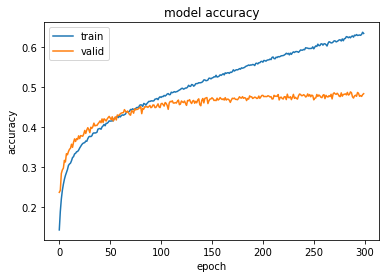

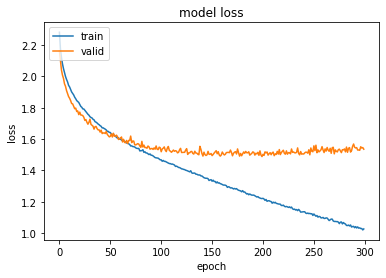

In [10]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [11]:
from sklearn.metrics import confusion_matrix
loss, acc = model.evaluate(x=x_test, y=y_test)
print(loss, acc)
targets = np.argmax(y_test, axis=-1)
probabilities = model.predict(x=x_test)
predictions = np.argmax(probabilities, axis=-1)
cm = confusion_matrix(y_true=targets, y_pred=predictions)
print(cm)

10000/10000 [==============================] - 0s 40us/step
1.520308122062683 0.4865
[[432  43 109  20 113  17  41  29 144  52]
 [ 11 600   5  34  40  11  68  23  55 153]
 [ 39  19 365  78 233  87  94  36  27  22]
 [ 23  19  91 272 146 178 161  51  13  46]
 [ 32  11 136  46 514  54 105  72  23   7]
 [ 13  10  98 143 139 426  74  69  12  16]
 [  9  33  80  52 137  36 600  24   9  20]
 [ 14  17  45  70 144  77  28 555  19  31]
 [ 97  89  31  41  70  12  35  21 556  48]
 [ 22 186  22  45  32  14  40  46  48 545]]


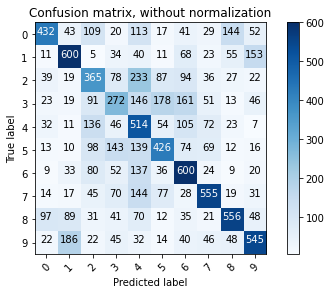

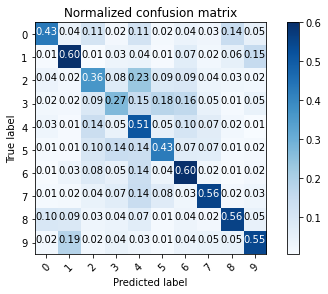

In [12]:
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    np.set_printoptions(precision=2)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

classes = np.arange(n_classes)
plot_confusion_matrix(cm, classes=classes)
plot_confusion_matrix(cm, classes=classes, normalize=True)

In [13]:
from sklearn.metrics import classification_report
report = classification_report(y_true=targets, y_pred=predictions, labels=classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

    airplane       0.62      0.43      0.51      1000
  automobile       0.58      0.60      0.59      1000
        bird       0.37      0.36      0.37      1000
         cat       0.34      0.27      0.30      1000
        deer       0.33      0.51      0.40      1000
         dog       0.47      0.43      0.45      1000
        frog       0.48      0.60      0.53      1000
       horse       0.60      0.56      0.58      1000
        ship       0.61      0.56      0.58      1000
       truck       0.58      0.55      0.56      1000

    accuracy                           0.49     10000
   macro avg       0.50      0.49      0.49     10000
weighted avg       0.50      0.49      0.49     10000



In [14]:
# top errors
from sklearn.metrics import log_loss
max_probs = np.max(probabilities, axis=-1)
losses = [log_loss(y_true=y, y_pred=prob, eps=1e-7) for y,prob in zip(y_test,probabilities)]
print('loss\tindex\ttrue\tpredicted\tprobability')
top_errors = sorted(list(zip(losses, np.arange(test_size), [class_names[i] for i in targets], [class_names[i] for i in predictions], max_probs)), reverse=True)[:32]
titles = []
inds = []
for i,error in enumerate(top_errors):
    titles.append('%s -> %s'%(error[2],error[3]))
    inds.append(error[1])
    if i<10:
        print('%.04f\t%d\t%s\t%s\t\t%.04f'%error)
        #plt.figure()
        #plt.imshow(raw_x_test[error[1]], cmap='gray')

loss	index	true	predicted	probability
1.7691	8901	dog	horse		0.9998
1.4118	5175	frog	automobile		0.9896
1.3854	9529	truck	dog		0.5507
1.3390	6688	automobile	horse		0.9576
1.2852	2895	horse	dog		0.9842
1.2641	4748	airplane	automobile		0.9901
1.2467	2323	ship	automobile		0.9955
1.2349	6453	ship	automobile		0.9913
1.1543	2405	cat	frog		0.9955
1.1417	9871	truck	automobile		0.9966


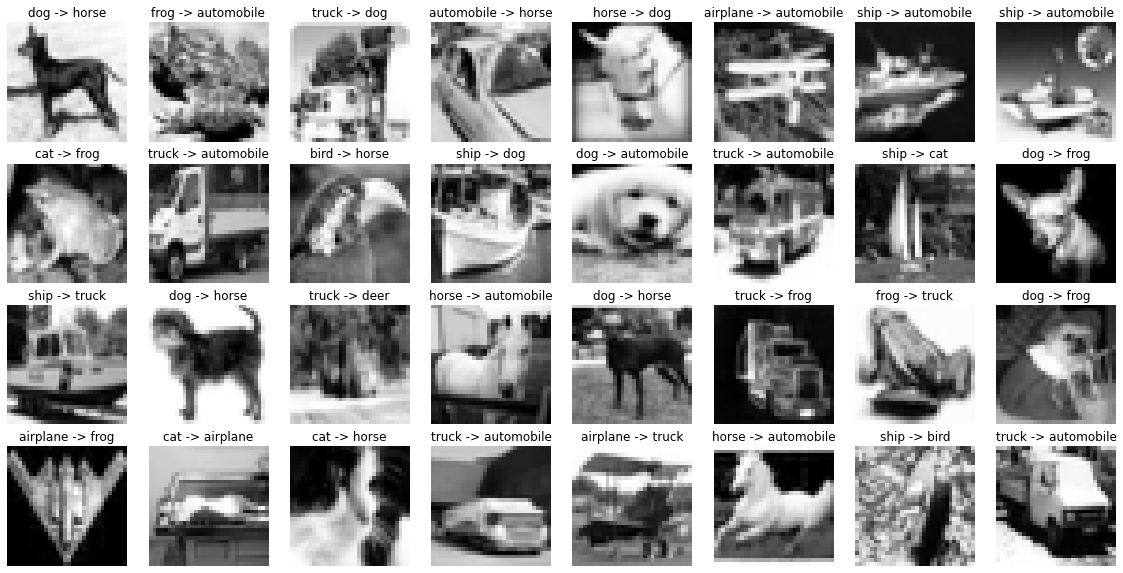

In [15]:
show_grid(raw_x_test[inds[:32]],4,8,label_list=titles[:32],show_labels=True,figsize=(20,10))